# Example use of data simulation

This ipynb file cointains an example on how to simulate data.

## Import functions
This section imports functions used in this notebook. 

In [37]:
import json
from simulation import Simulation, gen_drop_out
import numpy as np
np.random.seed(42)

## Define Parameters
This sections defines parameters for our study. Most important parameters are stored in a seperate json file. 

In [38]:
# Load example params
with open("example/example_params.json") as fp:
    study_params = json.load(fp)

# study design defines the order of treatmens. None indicates no-treatment was given
study_design = ["Treatment_1","Treatment_2", "Treatment_1","Treatment_2"]

days_per_period = 28


## Create Patient
First, we create a simulation object with our study params. These assumptions are equal for all patients in our study. Afterwards we can generate patients with different study design, days per period and drop out. It returns 2 dataframes:

* complete with all features
* patient with dropout values

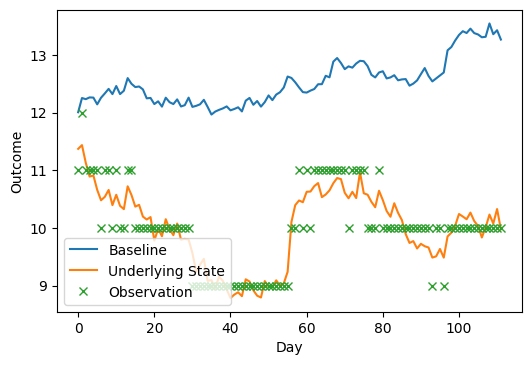

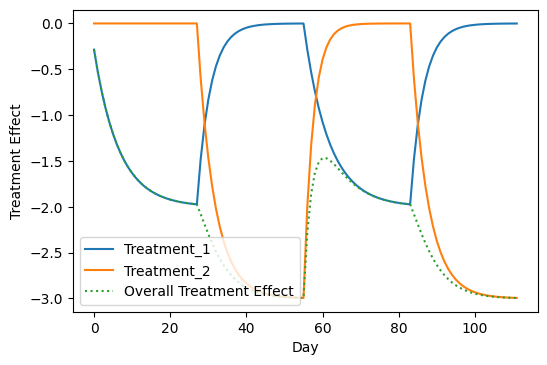

In [39]:
sim = Simulation(study_params)
pat_complete = sim.gen_patient(study_design, days_per_period, drop_out=None)

sim.plot_patient(pat_complete)

# Generate Missing Values

In [44]:
np.random.seed(42)
# Drop out fraction to simulate drop out
res = pat_complete.copy()

res["MNAR_weight"] = (1-res["Uncertain_Low_Back_Pain"] / 15)

drop_outs=[
    {
    "fraction":0.7,
    "kind":"MCAR"
    },
    {
    "fraction":0.7,
    "kind":"MAR"
    },
    {
    "fraction":0.7,
    "kind":"MNAR",
    "mnar_weight_column":"MNAR_weight"
    }]

for drop_out in drop_outs:
    res[drop_out["kind"]] = gen_drop_out(res, **drop_out)["missing"]
res.to_csv("Example_Missing_Values.csv")

In [53]:
print("Missing Vales:")
print(round(res[["MCAR","MNAR","MAR"]].mean(axis=0)*100,2).astype(str) + "%")

Missing Vales:
MCAR    30.36%
MNAR    30.36%
MAR     30.36%
dtype: object


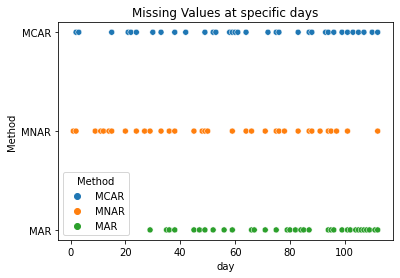

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns

plt_data = res[["MCAR","MNAR","MAR","day","Uncertain_Low_Back_Pain"]].melt(id_vars=["day","Uncertain_Low_Back_Pain"], var_name="Method")
plt_data = plt_data[plt_data["value"]]
sns.scatterplot(data=plt_data, x="day", y="Method", hue="Method")
plt.title("Missing Values at specific days")
plt.show()

In [56]:
import pandas as pd
cross_tab = pd.crosstab(res["MNAR"], res["Uncertain_Low_Back_Pain"])
#cross_tab
round( cross_tab / cross_tab.sum(axis=0) * 100 ,2).astype(str) + "%"

Uncertain_Low_Back_Pain,9,10,11,12
MNAR,,,,
False,67.86%,77.19%,57.69%,0.0%
True,32.14%,22.81%,42.31%,100.0%


In [49]:
round(pd.crosstab(res["MAR"], res["block"]) / len(res) * 100 ,2).astype(str) + "%"

cross_tab = pd.crosstab(res["MAR"], res["block"])
round( cross_tab / cross_tab.sum(axis=0) * 100 ,2).astype(str) + "%"

block,1,2,3,4
MAR,,,,
False,100.0%,67.86%,67.86%,42.86%
True,0.0%,32.14%,32.14%,57.14%
